# Chapter 2: Taking Earth's Temperature

### Outline
1. [Long-term temperature evolution based on different data sources](#first-bullet)
2. [Recent temperature anomalies](#second-bullet)

### Section 1. Long-term temperature evolution in different data sets <a class="anchor" id="first-bullet"></a>

This tutorial walks you through analyzing and visualizing temperature data from the ERA5 reanalysis product reproducing main figures from the monthly <a href="https://climate.copernicus.eu/climate-bulletins">climate bulletins</a>.

#### Import libraries

In [156]:
# Python Standard Libraries
import os  
import datetime as dt
import zipfile
import urllib.request
from string import ascii_lowercase as ABC 

# Data Manipulation Libraries
import numpy as np 
import pandas as pd
import xarray as xr
import regionmask as rm

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates 
import cartopy.crs as ccrs 

plt.style.use('../copernicus.mplstyle')  # Set the visual style of the plots; not necessary for the tutorial

# Climate Data Store API for retrieving climate data
import cdsapi

#### Download temperature data from different sources

* Berkeley Earth (available in CDS as land-only)
* NOAA Global Temperature v5
* GISTEMP (available in CDS as globally averaged time series only)
* HadCRUT5
* ERA5


We will create dedicated folder for each data set

In [157]:
file_name = {}  # dictionary containing [data source : file name]

# Add the data sources and file names
file_name.update({'berkeley': 'temperature_berkeley.nc'})  # is not available as netCDF, only as zip file
file_name.update({'gistemp': 'temperature_gistemp.gz'}) # is not available as netCDF, only as zip file
file_name.update({'hadcrut': 'temperature_hadcrut.nc'})
file_name.update({'era5': 'temperature_era5.nc'})
file_name.update({'eobs': 'temperature_eobs.tar.gz'})

# Create the paths to the files
path_to = {source: os.path.join(f'data/{source}/', file) for source, file in file_name.items()}

# Create necessary directories if they do not exist
for path in path_to.values():
    os.makedirs(os.path.dirname(path), exist_ok=True) # create the folder if not available

path_to

{'berkeley': 'data/berkeley/temperature_berkeley.nc',
 'gistemp': 'data/gistemp/temperature_gistemp.gz',
 'hadcrut': 'data/hadcrut/temperature_hadcrut.nc',
 'era5': 'data/era5/temperature_era5.nc',
 'eobs': 'data/eobs/temperature_eobs.tar.gz'}

In [158]:
def streamline_coords(da):
    '''Streamline the coordinates of a DataArray.
    
    Parameters
    ----------
    da : xr.DataArray
        The DataArray to streamline.
    '''

    # Ensure that time coordinate is fixed to the first day of the month
    if 'time' in da.coords:
        da.coords['time'] = da['time'].to_index().to_period('M').to_timestamp()
            

    # Ensure that spatial coordinates are called 'lon' and 'lat'
    if 'longitude' in da.coords:
        da = da.rename({'longitude': 'lon'})
    if 'latitude' in da.coords:
        da = da.rename({'latitude': 'lat'})

    # Ensure that lon/lat are sorted in ascending order
    da = da.sortby('lat')
    da = da.sortby('lon')

    # Ensure that lon is in the range [-180, 180]
    lon_min = da['lon'].min()
    lon_max = da['lon'].max()
    if lon_min < -180 or lon_max > 180:
        da.coords['lon'] = (da.coords['lon'] + 180) % 360 - 180
        da = da.sortby(da.lon)
    
    return da

##### NOAA GlobalTemp

Here we're going to access the data from [NOAA](https://www.ncei.noaa.gov/products/land-based-station/noaa-global-temp) using OPeNDAP. OPeNDAP is a protocol that allows for the remote access of scientific data stored in various formats over the internet. xarray is quite handy and allows to access data directly via OPENDAP. So retrieving data from NOAA basically becomes a one-liner:

In [159]:
url_to_noaa = 'https://www.ncei.noaa.gov/thredds/dodsC/noaa-global-temp-v5.1/NOAAGlobalTemp_v5.1.0_gridded_s185001_e202306_c20230708T112624.nc'
noaa = xr.open_dataset(url_to_noaa)
noaa

<xarray.Dataset>
Dimensions:  (time: 2082, lat: 36, lon: 72, z: 1)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-06-01
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * z        (z) float32 0.0
Data variables:
    anom     (time, z, lat, lon) float32 ...
Attributes: (12/66)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           NOAA Merged Land Ocean Global Surface Te...
    summary:                         NOAAGlobalTemp is a merged land-ocean su...
    institution:                     DOC/NOAA/NESDIS/National Centers for Env...
    id:                               gov.noaa.ncdc:C00934 
    naming_authority:                 gov.noaa.ncei 
    ...                              ...
    time_coverage_duration:          P173Y6M
    references:                      Vose, R. S., et al., 2012: NOAAs merged ...
    climatology:                     Climatology is based on 1971-2000 monthl...
    acknowledgment:                  The NOAA Global Surface Temperature Data...
    date_modified:                   2023-07-08T15:26:25Z
    date_issued:                     2023-07-08T15:26:25Z

Let's remove the redundant z coordinate. Also note that we already have anomaliy data.

In [160]:
noaa = noaa['anom'].isel(z=0, drop=True)

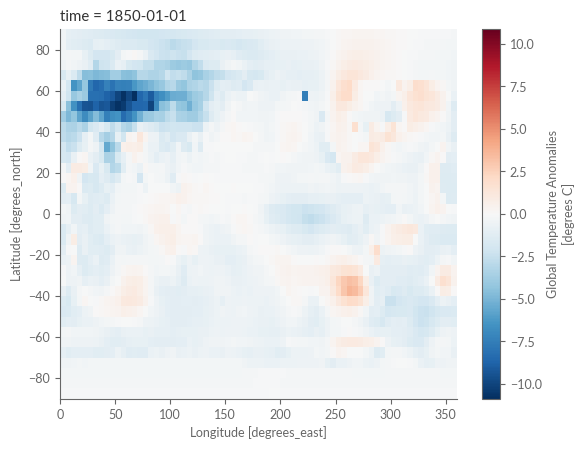

In [161]:
noaa.isel(time=0).plot()

##### Berkeley Earth
Next, we set up the directory where we will download and store our data.

NOTE: In the CDS, Berkeley Earth is only available over land. We need ocean as well, so let's take the data from the official provider:  https://berkeleyearth.org/data/ Global Montly Land - Ocean, 1x1 La-Lon Grid

The data is about 400 MB so depending on your downloading speed the process may take a while.

In [6]:
url_berkeley = 'https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Gridded/Land_and_Ocean_LatLong1.nc'
urllib.request.urlretrieve(url_berkeley, path_to['berkeley'])


('data/berkeley/temperature_berkeley.nc',
 <http.client.HTTPMessage at 0x7f0c1c6bb070>)

In [162]:
berkeley = xr.open_dataset(path_to['berkeley'])
berkeley

<xarray.Dataset>
Dimensions:      (longitude: 360, latitude: 180, time: 2079, month_number: 12)
Coordinates:
  * longitude    (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude     (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time         (time) float64 1.85e+03 1.85e+03 ... 2.023e+03 2.023e+03
Dimensions without coordinates: month_number
Data variables:
    land_mask    (latitude, longitude) float64 ...
    temperature  (time, latitude, longitude) float32 ...
    climatology  (month_number, latitude, longitude) float32 ...
Attributes:
    Conventions:           Berkeley Earth Internal Convention (based on CF-1.5)
    title:                 Native Format Berkeley Earth Surface Temperature A...
    history:               20-Apr-2023 07:02:14
    institution:           Berkeley Earth Surface Temperature Project
    land_source_history:   05-Apr-2023 08:20:01
    ocean_source_history:  20-Apr-2023 05:22:16
    comment:               This file contains Berkeley Earth surface temperat...

It's not really common the report the time as floats, so let's convert it to datetime objects.

In [163]:
new_time_coords = xr.cftime_range(start='1850-01-01', periods=berkeley.time.size, freq='MS').to_datetimeindex()
berkeley.coords.update({'time': new_time_coords})

berkeley_land_mask = berkeley['land_mask']
berkeley = berkeley['temperature']

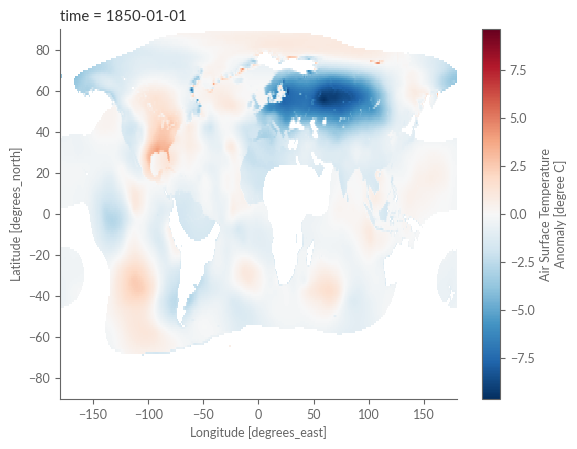

In [164]:
berkeley.isel(time=0).plot()

NOTE: Berkeley recently rolled out a new machine learning augmented version providing a comprehensive, high-resolution instrumental temperature record back to 1750.

##### GISTEMP

We want the original gridded data (CDS only has time series), so head over to the NASA website: https://data.giss.nasa.gov/gistemp/
We download the [Land-Ocean Temperature Index, ERSSTv5, 1200km smoothing](https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz) in the following:

In [74]:
url_gistemp_1200km = 'https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz'
url_gistemp_250km = 'https://data.giss.nasa.gov/pub/gistemp/gistemp250_GHCNv4.nc.gz'
url_gistemp_land_sea_mask = 'https://data.giss.nasa.gov/pub/gistemp/landmask.2degx2deg.txt'

urllib.request.urlretrieve(url_gistemp_1200km, 'data/gistemp/temperature_gistemp_1200km.gz')
urllib.request.urlretrieve(url_gistemp_250km, 'data/gistemp/temperature_gistemp_250km.gz')
urllib.request.urlretrieve(url_gistemp_land_sea_mask, 'data/gistemp/temperature_gistemp_land_sea_mask.txt')

('data/gistemp/temperature_gistemp_land_sea_mask.gz',
 <http.client.HTTPMessage at 0x7f0aa6a12e90>)

In [165]:
with xr.open_dataset('data/gistemp/temperature_gistemp_1200km.gz') as gistemp_1200:
    gistemp_1200 = gistemp_1200['tempanomaly']
with xr.open_dataset('data/gistemp/temperature_gistemp_250km.gz') as gistemp_250:
    gistemp_250 = gistemp_250['tempanomaly']

gistemp_1200

<xarray.DataArray 'tempanomaly' (time: 1722, lat: 90, lon: 180)>
[27896400 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time     (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2023-06-15
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

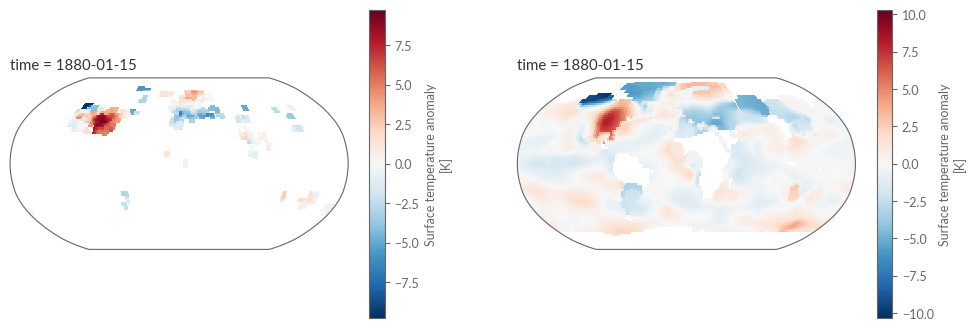

In [166]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), subplot_kw={'projection': ccrs.Robinson()})
gistemp_250.isel(time=0).plot(ax=axes[0], transform=ccrs.PlateCarree())
gistemp_1200.isel(time=0).plot(ax=axes[1], transform=ccrs.PlateCarree())

In [167]:
gistemp = gistemp_250.where(gistemp_250.notnull(), other=gistemp_1200)

In [168]:
gistemp_land_sea_mask = pd.read_csv('data/gistemp/temperature_gistemp_land_sea_mask.txt', sep='\s+', header=1, names=['lat', 'lon', 'mask'])
gistemp_land_sea_mask

,,lat,lon,mask
1,1,-179.0,-89.0,1.0
2,1,-177.0,-89.0,1.0
3,1,-175.0,-89.0,1.0
4,1,-173.0,-89.0,1.0
5,1,-171.0,-89.0,1.0
...,...,...,...,...
176,90,171.0,89.0,0.0
177,90,173.0,89.0,0.0
178,90,175.0,89.0,0.0
179,90,177.0,89.0,0.0


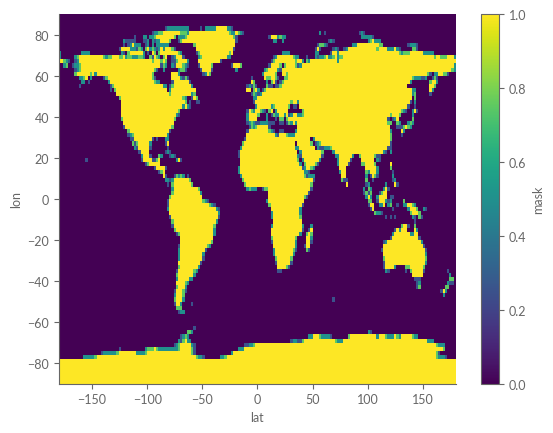

In [169]:
gistemp_land_sea_mask = gistemp_land_sea_mask.set_index(['lon', 'lat']).to_xarray()['mask']
gistemp_land_sea_mask.plot()

Hourey! That looks good!

##### HadCRUT5

Now let's get the HadCRUT version 5 from the MetOffice. They also provide a separate file containing the weights that should be used to weigh the ocean and land grid cells. So we'll get that as well to follow their methodology.

In [11]:
url_hadcrut = 'https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc'
url_hadcrut_weights = 'https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/HadCRUT.5.0.1.0.analysis.weights.nc'
urllib.request.urlretrieve(url_hadcrut, path_to['hadcrut']fontsize=16, fontweight='bold'
urllib.request.urlretrieve(url_hadcrut_weights, 'data/hadcrut/temperature_weights.nc')

('data/hadcrut/temperature_weights.nc',
 <http.client.HTTPMessage at 0x7f7cd9822170>)

In [170]:
with xr.open_dataset(path_to['hadcrut']) as hadcrut:
    hadcrut = hadcrut['tas_mean']

with xr.open_dataset('data/hadcrut/temperature_weights.nc') as hadcrut_weights:
    hadcrut_weights = hadcrut_weights['weights']
hadcrut

<xarray.DataArray 'tas_mean' (time: 2079, latitude: 36, longitude: 72)>
[5388768 values with dtype=float64]
Coordinates:
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2023-03-16T12:...
  * latitude     (latitude) float64 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * longitude    (longitude) float64 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
    realization  int64 ...
Attributes:
    long_name:     blended air_temperature_anomaly over land with sea_water_t...
    units:         K
    cell_methods:  area: mean (interval: 5.0 degrees_north 5.0 degrees_east) ...

HadCRUT5 also provides direct access to its individual ensemble members (200 in total). The idea behind the ensemble members is that they catch the sensitivity to initial conditions and thus the underlying uncertainty of the model. Each ensemble member is a slighlty different realization. Here we just download the first 10 members (~300 MB) of the 200 to save up some computational and memory time. Ideally, you want to run the following lines with all 200 members. First, let's get the first batch of ensemble members:

In [171]:
url_hadcrut_ens_members = 'https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/HadCRUT.5.0.1.0.analysis.anomalies.1_to_10_netcdf.zip'
urllib.request.urlretrieve(url_hadcrut_ens_members, 'data/hadcrut/temperature_ensemble_members.zip')

('data/hadcrut/temperature_ensemble_members.zip',
 <http.client.HTTPMessage at 0x7f0a9f1d74f0>)

In [172]:
with zipfile.ZipFile('data/hadcrut/temperature_ensemble_members.zip') as z:
    z.extractall('data/hadcrut/')

hadcrut_members = xr.open_mfdataset('data/hadcrut/*analysis*.nc', combine='nested', concat_dim='realization')
hadcrut_members

<xarray.Dataset>
Dimensions:         (realization: 10, time: 2081, latitude: 36, longitude: 72,
                     bnds: 2)
Coordinates:
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2023-05-16T...
  * latitude        (latitude) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude       (longitude) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
  * realization     (realization) int64 1 10 2 3 4 5 6 7 8 9
Dimensions without coordinates: bnds
Data variables:
    tas             (realization, time, latitude, longitude) float64 dask.array<chunksize=(1, 2081, 36, 72), meta=np.ndarray>
    time_bnds       (realization, time, bnds) datetime64[ns] dask.array<chunksize=(1, 2081, 2), meta=np.ndarray>
    latitude_bnds   (realization, latitude, bnds) float64 dask.array<chunksize=(1, 36, 2), meta=np.ndarray>
    longitude_bnds  (realization, longitude, bnds) float64 dask.array<chunksize=(1, 72, 2), meta=np.ndarray>
Attributes:
    comment:      2m air temperature over land blended with sea water tempera...
    history:      Data set built at: 2023-07-07T15:43:40+00:00
    institution:  Met Office Hadley Centre / Climatic Research Unit, Universi...
    licence:      HadCRUT5 is licensed under the Open Government Licence v3.0...
    reference:    C. P. Morice, J. J. Kennedy, N. A. Rayner, J. P. Winn, E. H...
    source:       CRUTEM.5.0.1.0 HadSST.4.0.0.0
    title:        HadCRUT.5.0.1.0 blended land air temperature and sea-surfac...
    version:      HadCRUT.5.0.1.0
    Conventions:  CF-1.7

In [173]:
hadcrut_members = hadcrut_members['tas'].compute()

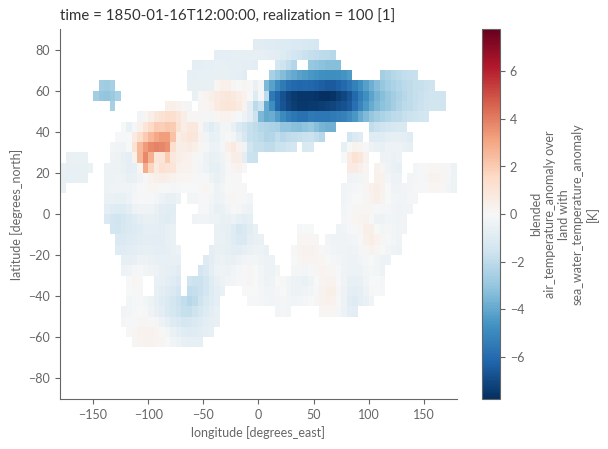

In [174]:
hadcrut.isel(time=0).plot()

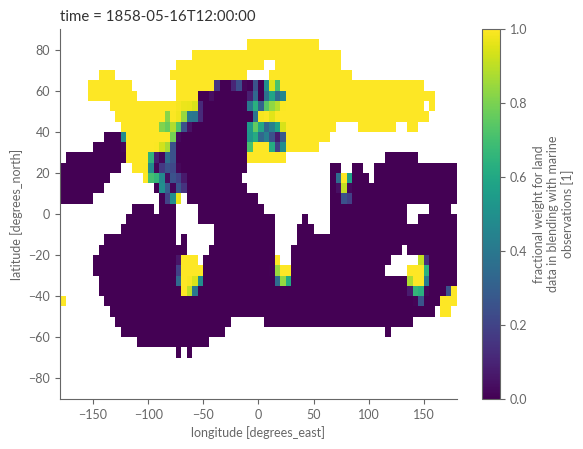

In [176]:
hadcrut_weights.isel(time=100).plot()

##### ERA5 reanalysis

Now, let's retrieve our data from the CDS using the `cdsapi.Client()`. Here, we download the reanalysis ERA5 single levels monthly means data for the variable '2m_temperature' from 1950 to 2022.

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    For efficiency and to expedite processing time, we are opting to download the data at a coarser resolution of 1x1 degree, as opposed to the highest (default) resolution of 0.25x0.25 degree. Please be aware that this could lead to minor discrepancies when compared to figures published in <a href="https://climate.copernicus.eu/climate-bulletins">climate intelligence bulletins.</a>
</div>

<div class="alert alert-block alert-info">
<b>NOTE</b>: <br>
    Please note that the time to request and download the data may vary as it depends on several factors. It typically should take less than 10 minutes though.
</div>

In [319]:
c = cdsapi.Client()

c.retrieve(
  'reanalysis-era5-single-levels-monthly-means',
  {
    'format': 'netcdf',
    'product_type': 'monthly_averaged_reanalysis',
    'variable': ['2m_temperature', 'land_sea_mask'],
    'year': list(range(1950, 2023)),
    'month': list(range(1, 13)),
    'time': '00:00',
    # 'grid': [0.25, 0.25],
  },
  path_to['era5']
)

2023-07-18 23:37:09,436 INFO Welcome to the CDS
2023-07-18 23:37:09,437 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-07-18 23:37:09,532 INFO Request is queued
2023-07-18 23:37:10,588 INFO Request is running
2023-07-18 23:47:29,182 INFO Request is completed
2023-07-18 23:47:29,184 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data9/adaptor.mars.internal-1689716608.4304297-30290-1-58d02187-6545-4a99-83e3-91816a555a27.nc to data/era5/temperature_era5.nc (3.4G)
2023-07-19 00:26:09,727 INFO Download rate 1.5M/s     


Result(content_length=3638006464,content_type=application/x-netcdf,location=https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data9/adaptor.mars.internal-1689716608.4304297-30290-1-58d02187-6545-4a99-83e3-91816a555a27.nc)

Once downloaded, we can load this data into an `xarray.DataArray`.

In [320]:
with xr.open_dataset(path_to['era5']) as era5:
  # convert from Kelvin to Celsius
  era5['t2m'] = era5['t2m'] - 273.15 

era5_land_sea_mask = era5['lsm']
era5 = era5['t2m']

Good to know: When dealing with temperature anomalies, the focus is on the change in temperature from a baseline or reference value, rather than the absolute temperature itself. This means we're interested in the difference or deviation from a reference point, which remains the same regardless of whether the temperature scale is Celsius, Kelvin, or Fahrenheit.

#### Streamline the different data sets

Let's streamline the different data sets such that they have the same variable and dimension names.

In [321]:
berkeley = streamline_coords(berkeley)
berkeley_land_mask = streamline_coords(berkeley_land_mask)
hadcrut = streamline_coords(hadcrut)
hadcrut_weights = streamline_coords(hadcrut_weights)
hadcrut_members = streamline_coords(hadcrut_members)
era5 = streamline_coords(era5)
era5_land_sea_mask = streamline_coords(era5_land_sea_mask)
noaa = streamline_coords(noaa)
gistemp = streamline_coords(gistemp)
gistemp_land_sea_mask = streamline_coords(gistemp_land_sea_mask)

noaa.name = 'noaa'
berkeley.name = 'berkeley'
gistemp.name = 'gistemp'
hadcrut_members.name = 'hadcrut'
hadcrut.name = 'hadcrut'
era5.name = 'era5'

Now that we have all the data in the same format (time, lon, lat) and in anomalies, we can proceed with the analysis. Next step involves creating a mask for the regions of interest. We will use the regionmask package for this purpose. The package provides a number of predefined regions including a land sea mask. We're going to use this mask for the data sets which did not come with a pre-defined land sea mask.

In [322]:
lsm = rm.defined_regions.natural_earth_v5_0_0.land_110

land_sea_mask = {
    'berkeley': berkeley_land_mask,
    'hadcrut': hadcrut_weights,
    'era5': era5_land_sea_mask,
    'noaa': lsm.mask(noaa).notnull(),
    'gistemp': gistemp_land_sea_mask
}

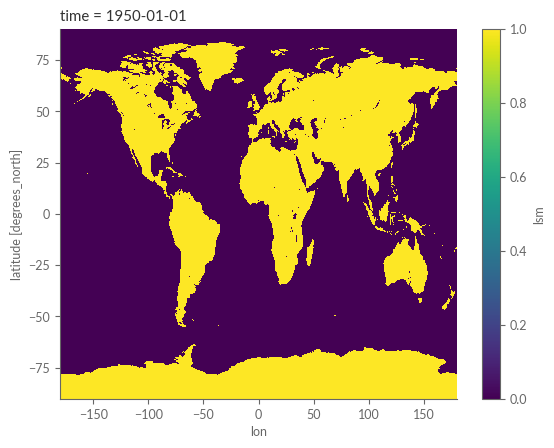

In addtion, we want to be able to create regional subselections. Here, we create some regions of interest. Just create your own one if needed.

In [323]:
region_of_interest = {
    'Global': {'lon': slice(-180, 180), 'lat': slice(-90, 90)},
    'Northern Hemisphere': {'lon': slice(-180, 180), 'lat': slice(0, 90)},
    'Southern Hemisphere': {'lon': slice(-180, 180), 'lat': slice(-90, 0)},
    'Europe': {'lon': slice(-20, 40), 'lat': slice(35, 80)},
    'Arctic': {'lon': slice(-180, 180), 'lat': slice(60, 90)},
}

#### Limited spatial coverage in the past can lead to biases

Text(0.5, 1.0, '1950')

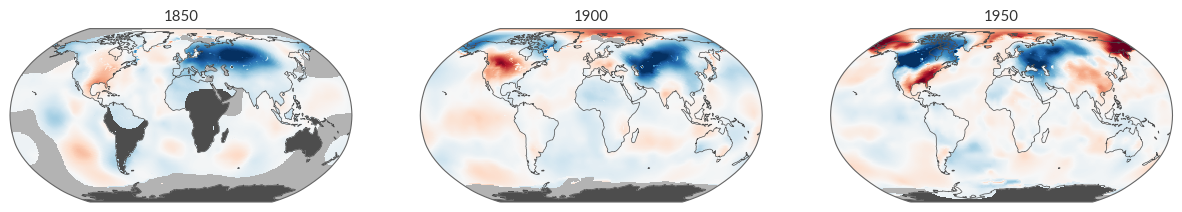

In [324]:
# Note that the farer back in time we go, the less of the globe is covered by the data illustrating the limited in-situ measurements available in the prior centuries.
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(15, 5))
ax = [plt.subplot(1, 3, i+1, projection=ccrs.Robinson()) for i in range(3)]
kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-8, vmax=8, add_colorbar=False)
berkeley.sel(time='1850-01').plot(ax=ax[0], **kwargs)
berkeley.sel(time='1900-01').plot(ax=ax[1], **kwargs)
berkeley.sel(time='1950-01').plot(ax=ax[2], **kwargs)
for a in ax:
    a.coastlines(lw=.5, color='.3')
    a.add_feature(cfeature.LAND, lw=.5, color='.3')
    a.add_feature(cfeature.OCEAN, lw=.5, color='.7')
    a.set_global()
    a.set_title('')
ax[0].set_title('1850', loc='center')
ax[1].set_title('1900', loc='center')
ax[2].set_title('1950', loc='center')

Note that at the beginning of the instrumental period, the temperature data has considerable gaps around the globe. This is due to the limited number of in-situ measurements available at that time. The coverage increases over time as more and more measurements become available. However, the reduced spatial coverage in the past, especially so in the Southern Hemisphere, can lead to biases which should be reflected in the associated uncertainties.

#### Comparing the data sets

First lets convert ERA5 from ansolute values to anomalies by subtracting the 1991-2020 climatology. 

In [325]:
ref_period = slice('1991', '2020')

In [326]:
def weighted_spatial_average(da, region_of_interest, land_only=False):
    '''Calculate the weighted spatial average of a DataArray.
    
    Parameters
    ----------
    da : xr.DataArray
        The DataArray to average.
    weights : xr.DataArray, optional
        A DataArray with the same dimensions as `da` containing the weights.
    '''
    
    # Area weighting: calculate the area of each grid cell
    weights = np.cos(np.deg2rad(da.lat))
    
    # Additional user-specified weights, e.g. land-sea mask
    if land_only:
        try:
            lsm = land_sea_mask[da.name]
        except KeyError:
            raise KeyError(f'No land-sea mask available for {da.name}.')
        weights = weights * lsm.fillna(0)
    
    return da.sel(**region_of_interest).weighted(weights).mean(('lat', 'lon'))

In [351]:
# get days per months for time coordinate
# days_per_month = berkeley.time.dt.days_in_month
days_in_month = era5.time.dt.days_in_month

In [354]:
x = era5.sel(time=ref_period)
x = x.sel(region_of_interest['Arctic'])
weights = era5_land_sea_mask.sel(region_of_interest['Arctic'])
weights = weights * np.cos(np.deg2rad(x.lat))
xs = (x * weights).sum(('lat', 'lon'))
ws = weights.sum(('lat', 'lon'))
x = xs / ws
x

<xarray.DataArray (time: 360)>
array([-2.62283440e+01, -2.56130600e+01, -2.09553299e+01, -1.05968084e+01,
       -1.27455699e+00,  7.04489660e+00,  1.12339487e+01,  7.92311859e+00,
        1.30204260e+00, -9.02917957e+00, -1.84319878e+01, -2.49961758e+01,
       -2.55855522e+01, -2.46423759e+01, -1.90570660e+01, -1.35324993e+01,
       -2.79943252e+00,  5.15963125e+00,  9.41693687e+00,  6.61234713e+00,
       -9.69960332e-01, -1.02606716e+01, -2.12720699e+01, -2.41149197e+01,
       -2.50378551e+01, -2.32272205e+01, -1.88629742e+01, -1.14801922e+01,
       -1.86783206e+00,  6.96348953e+00,  1.07431850e+01,  7.02278042e+00,
        2.59446383e-01, -9.14070225e+00, -1.99296017e+01, -2.58054848e+01,
       -2.82728558e+01, -2.64956551e+01, -1.96499271e+01, -1.07943344e+01,
       -1.50124621e+00,  6.68942165e+00,  1.08491592e+01,  7.60777617e+00,
        7.94932246e-01, -8.13530540e+00, -2.02853165e+01, -2.52359791e+01,
       -2.43588238e+01, -2.16274261e+01, -1.95514259e+01, -8.76137447e+00,
       -1.30926371e+00,  7.06772041e+00,  9.86508846e+00,  8.24699783e+00,
        1.44978714e+00, -8.79121399e+00, -1.76464405e+01, -2.46057224e+01,
       -2.60350037e+01, -2.34477291e+01, -1.78875465e+01, -1.11194973e+01,
       -2.25894141e+00,  5.85579681e+00,  1.02643471e+01,  6.27308750e+00,
       -3.60006571e-01, -9.92278004e+00, -1.74122181e+01, -2.42771606e+01,
       -2.69761696e+01, -2.45983334e+01, -1.91506062e+01, -8.96951866e+00,
       -1.59459519e+00,  6.65941048e+00,  9.95879459e+00,  7.62654209e+00,
...
        1.18849790e+00, -8.49815083e+00, -1.81477566e+01, -2.25415516e+01,
       -2.53973122e+01, -2.36395760e+01, -1.76759434e+01, -1.01636887e+01,
       -5.70329785e-01,  7.71804190e+00,  1.04587545e+01,  7.58902550e+00,
        1.76315188e+00, -7.72506475e+00, -1.74865150e+01, -2.33195648e+01,
       -2.25771103e+01, -2.17457752e+01, -1.69655571e+01, -8.36933136e+00,
       -7.86876772e-03,  8.79515743e+00,  1.17146759e+01,  8.85080910e+00,
        2.80785751e+00, -6.74701309e+00, -1.77736282e+01, -2.40051422e+01,
       -2.43945599e+01, -2.27237759e+01, -1.59567327e+01, -1.01210442e+01,
       -1.41596639e+00,  7.33081865e+00,  1.03439598e+01,  8.73457241e+00,
        1.71662891e+00, -7.17967987e+00, -1.74319477e+01, -2.07508144e+01,
       -2.41082020e+01, -2.30683327e+01, -2.00497208e+01, -1.01235113e+01,
       -2.12070036e+00,  7.88986063e+00,  1.07204771e+01,  8.08068562e+00,
        1.65552795e+00, -6.15624380e+00, -1.79422035e+01, -2.23481865e+01,
       -2.55694160e+01, -2.27502956e+01, -1.58422575e+01, -8.81174660e+00,
        1.16107203e-01,  8.60558891e+00,  1.10936422e+01,  8.71417236e+00,
        2.29975581e+00, -6.38053322e+00, -1.70149765e+01, -2.29167919e+01,
       -2.39394188e+01, -2.26664886e+01, -1.77606277e+01, -8.27494335e+00,
        1.76811054e-01,  8.86928177e+00,  1.11240597e+01,  8.83271885e+00,
        2.39869738e+00, -6.03566122e+00, -1.49967556e+01, -2.25227413e+01],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1991-01-01 1991-02-01 ... 2020-12-01

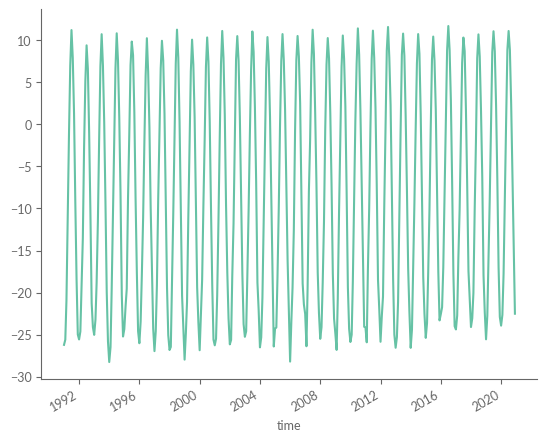

<xarray.DataArray ()>
array(-8.57632, dtype=float32)

In [357]:
x.plot()
plt.show()
x.mean()

In [ ]:
import xeofs as xe

cpca = xe.models.ComplexEOF(n_modes=10)
cpca.fit(data, dim=<sample dimension>)

patterns = cpca.components_amplitude()
phase = cpca.components_phase()
pcs = cpca.scores()  # principal components; achtung, complex!

In [ ]:
rot = xe.rotator.ComplexEOFRotator(n_modes=10)
rot.fit(cpca)

rotated_patterns = rot.components_amplitude()
rotated_phase = rot.components_phase()
rotated_pcs = rot.scores()  # principal components; achtung, complex!

In [356]:
# get number of days per month
days_in_month = x.time.dt.days_in_month
xmean = (x * days_in_month).sum() / days_in_month.sum()
xmean

<xarray.DataArray ()>
array(-8.49744485)

In [277]:
region = 'Global'
land_only = False

a = weighted_spatial_average(hadcrut, region_of_interest[region], land_only)
a_ens = weighted_spatial_average(hadcrut_members, region_of_interest[region], land_only)
b = weighted_spatial_average(berkeley, region_of_interest[region], land_only)
c = weighted_spatial_average(gistemp, region_of_interest[region], land_only)
d = weighted_spatial_average(noaa, region_of_interest[region], land_only)
e = weighted_spatial_average(era5, region_of_interest[region], land_only)


In [278]:
temp_mean_anom = xr.Dataset({'HadCRUT': a, 'HadCRUT_realizations': a_ens, 'Berkeley': b, 'GISTEMP': c, 'NOAA': d, 'ERA5': e})
temp_mean_anom

<xarray.Dataset>
Dimensions:               (time: 2082, realization: 10)
Coordinates:
  * time                  (time) datetime64[ns] 1850-01-01 ... 2023-06-01
  * realization           (realization) int64 1 10 2 3 4 5 6 7 8 9
Data variables:
    HadCRUT               (time) float64 -0.7094 -0.2946 -0.565 ... nan nan nan
    HadCRUT_realizations  (realization, time) float64 -0.6716 -0.1529 ... nan
    Berkeley              (time) float32 -0.6622 -0.1831 -0.3176 ... nan nan nan
    GISTEMP               (time) float32 nan nan nan nan ... 1.063 0.9784 1.152
    NOAA                  (time) float32 -0.698 -0.4819 -0.6046 ... 0.6319 0.74
    ERA5                  (time) float32 nan nan nan nan nan ... nan nan nan nan

In [279]:
temp_mean_anom = temp_mean_anom.groupby('time.month') - temp_mean_anom.sel(time=ref_period).groupby('time.month').mean()
temp_mean_anom = temp_mean_anom.rolling(time=60, center=True).mean()

In [280]:
temp_mean_anom

<xarray.Dataset>
Dimensions:               (time: 2082, realization: 10)
Coordinates:
  * time                  (time) datetime64[ns] 1850-01-01 ... 2023-06-01
    month                 (time) int64 1 2 3 4 5 6 7 8 9 ... 11 12 1 2 3 4 5 6
  * realization           (realization) int64 1 10 2 3 4 5 6 7 8 9
Data variables:
    HadCRUT               (time) float64 nan nan nan nan nan ... nan nan nan nan
    HadCRUT_realizations  (realization, time) float64 nan nan nan ... nan nan
    Berkeley              (time) float32 nan nan nan nan nan ... nan nan nan nan
    GISTEMP               (time) float32 nan nan nan nan nan ... nan nan nan nan
    NOAA                  (time) float32 nan nan nan nan nan ... nan nan nan nan
    ERA5                  (time) float32 nan nan nan nan nan ... nan nan nan nan

In [281]:
ci = temp_mean_anom['HadCRUT_realizations'].quantile([0.0, 1.0], dim='realization')

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [318]:
ref_level_1850 = temp_mean_anom.sel(time=slice('1850', '1900')).mean()
mean_ref_level_1850 = ref_level_1850.to_array().mean().item()
mean_ref_level_1850

-0.8875047908630117

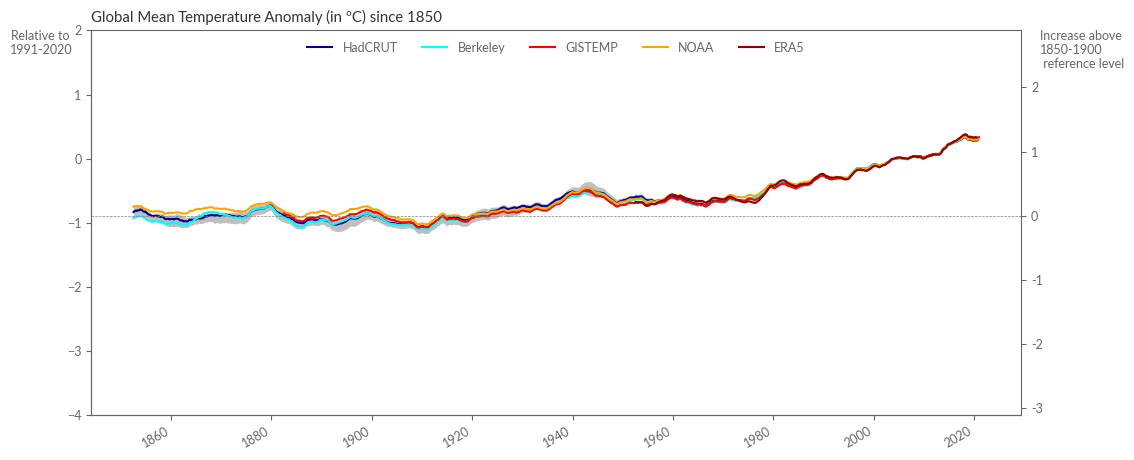

In [283]:

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
temp_mean_anom['HadCRUT'].plot(ax=ax, label='HadCRUT', color='darkblue')
temp_mean_anom['Berkeley'].plot(ax=ax, label='Berkeley', color='cyan')
temp_mean_anom['GISTEMP'].plot(ax=ax, label='GISTEMP', color='red')
temp_mean_anom['NOAA'].plot(ax=ax, label='NOAA', color='orange')
temp_mean_anom['ERA5'].plot(ax=ax, label='ERA5', color='darkred')
ax.fill_between(ci.time, ci.sel(quantile=0.0), ci.sel(quantile=1.0), color='.5', alpha=.5, lw=0, zorder=-1)
ax.legend(ncols=6, frameon=False, loc='upper center')


ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax.xaxis.set_major_locator(mdates.YearLocator(20))

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title(f'{region} Mean Temperature Anomaly (in ºC) since 1850')
ax.text(-.02, 1, 'Relative to \n1991-2020', rotation=0, ha='right', va='top', transform=ax.transAxes)
ax.text(1.02, 1, 'Increase above \n1850-1900\n reference level', rotation=0, ha='left', va='top', transform=ax.transAxes)
ax.axhline(mean_ref_level_1850, color='.5', lw=.5, ls='--')

yticks = np.arange(-10, 10, 1)
ax2_yticks = yticks + mean_ref_level_1850
ax2.set_yticks(ax2_yticks)
ax2.set_yticklabels(yticks)
ax.set_ylim(-4., 2)
ax2.set_ylim(-4, 2)

plt.show()

Taking Earth's temperature... using ERA5

In [306]:
# temp_mean = weighted_spatial_average(era5, region_of_interest[region], land_only)
# temp_mean.sel(time=ref_period).mean()
weights = np.cos(np.deg2rad(era5.lat))
weights = weights * era5_land_sea_mask.where(era5_land_sea_mask > .5, 0)
ok = era5.copy()
ok.sel(region_of_interest['Arctic']).weighted(weights).mean(('lat', 'lon')).sel(time=ref_period).mean()

<xarray.DataArray 'era5' ()>
array(-8.428164, dtype=float32)

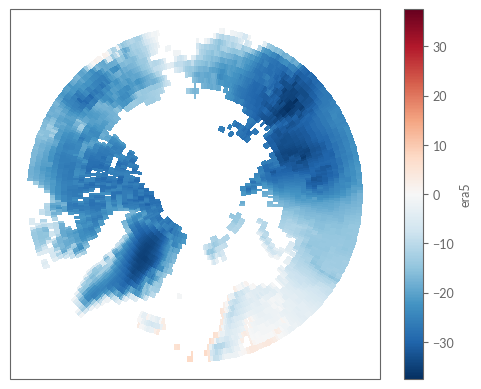

In [317]:
era5.isel(time=10).sel(lat=slice(60, None)).where(era5_land_sea_mask[0]).plot(subplot_kws=dict(projection=ccrs.NorthPolarStereo()), transform=ccrs.PlateCarree())

In [270]:
weights = np.cos(np.deg2rad(era5.lat))
weights = weights * era5_land_sea_mask
weights = weights.sel(region_of_interest['Arctic'])
ok = era5.sel(region_of_interest['Arctic'])
ok = (ok * weights).sum(('lat', 'lon')) / weights.sum(('lat', 'lon'))
ok.sel(time=ref_period).mean()

<xarray.DataArray ()>
array(-8.393121, dtype=float32)

In [57]:
# mean temperature in the reference period
mean_temp_ref_period = era5.sel(time=ref_period).weighted(np.cos(np.deg2rad(era5_anom.coords['lat']))).mean(('lon', 'lat')).mean()
print(f'The mean temperature in the reference period is {mean_temp_ref_period.values:.1f} °C.')

The mean temperature in the reference period is 14.4 °C.


## Section 2. Comparison between re-analysis and observations over the last century

Now that we have looked at the long-term evolution of temperture in different datasets, we want to focus on the last century, where reanalysis data exists. Reanalysis is a scientific method for developing a comprehensive record of how weather and climate are changing over time. It involves using a fixed version of a weather forecasting model and assimilating historical weather observations to generate a synthesized estimate of the state of the Earth's atmospheric conditions over time. The ECMWF's ERA5 is one of the most advanced global atmospheric reanalyses to date, providing hourly data on many atmospheric, land-surface, and sea-state parameters from 1940 onwards.

In the following we want to assess the validity of surface air temperatures obtained from ERA5 by comparing them to observational data. Here we take [E-OBS](https://www.ecad.eu/download/ensembles/download.php) as observational reference, which is a gridded dataset that provides daily observations of a number of weather variables, such as precipitation, temperature, and sea-level pressure, across Europe.


<div class="alert alert-block alert-info">
<b>NOTE</b>: <br>
    Please note that the time to request and download the data may vary as it depends on several factors. It typically should take less than 10 minutes though.
</div>

<div class="alert alert-block alert-info">
<b>NOTE</b>: <br>
    The gridded E-OBS data set is available at high (0.1º) or low (0.25º) resolution. Here we take the low resolution data set to speed up the downloading process.
</div>

In [366]:
c = cdsapi.Client()

c.retrieve(
    'insitu-gridded-observations-europe',
    {
        'format': 'tgz',
        'product_type': 'ensemble_mean',
        'variable': 'mean_temperature',
        'grid_resolution': '0.25deg',
        'period': 'full_period',
        'version': '27.0e',
    },
    path_to['eobs']
)

2023-07-18 15:53:14,551 INFO Welcome to the CDS
2023-07-18 15:53:14,552 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-europe
2023-07-18 15:53:14,633 INFO Request is queued
2023-07-18 15:53:15,688 INFO Request is running
2023-07-18 15:57:33,232 INFO Request is completed
2023-07-18 15:57:33,234 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data0/dataset-insitu-gridded-observations-europe-d9da22b6-2377-47a9-87f8-ff7d3bf107c6.tar.gz to data/eobs/temperature_eobs.nc (752.3M)
2023-07-18 16:07:21,410 INFO Download rate 1.3M/s  


Result(content_length=788796139,content_type=application/gzip,location=https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data0/dataset-insitu-gridded-observations-europe-d9da22b6-2377-47a9-87f8-ff7d3bf107c6.tar.gz)

In [58]:
import tarfile
  
# open file
file = tarfile.open(path_to['eobs'])
  
# print file names
print(file.getnames())
  
# extract files
file.extractall('data/eobs')

['tg_ens_mean_0.25deg_reg_v27.0e.nc']


In [59]:
eobs_daily = xr.open_mfdataset('data/eobs/tg_ens_mean_0.25deg_reg_v27.0e.nc')
eobs_daily

<xarray.Dataset>
Dimensions:    (time: 26663, longitude: 464, latitude: 201)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2022-12-31
  * longitude  (longitude) float64 -40.38 -40.12 -39.88 ... 74.88 75.12 75.38
  * latitude   (latitude) float64 25.38 25.62 25.88 26.12 ... 74.88 75.12 75.38
Data variables:
    tg         (time, latitude, longitude) float32 dask.array<chunksize=(26663, 201, 464), meta=np.ndarray>
Attributes:
    CDI:            Climate Data Interface version 2.0.5 (https://mpimet.mpg....
    Conventions:    CF-1.4
    E-OBS_version:  27.0e
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Mon May 08 11:44:20 2023: cdo -z zip_3 mergetime tg_ens_m...
    NCO:            netCDF Operators version 4.7.5 (Homepage = http://nco.sf....
    CDO:            Climate Data Operators version 2.0.5 (https://mpimet.mpg....

In [60]:
eobs_daily = eobs_daily['tg']
eobs_daily = streamline_coords(eobs_daily)
eobs_daily.name = 'eobs'
eobs_daily

<xarray.DataArray 'eobs' (time: 26663, lat: 201, lon: 464)>
dask.array<open_dataset-4a01d6845c74e5fcec70923e8c9e7b92tg, shape=(26663, 201, 464), dtype=float32, chunksize=(26663, 201, 464), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-01-01 ... 2022-12-01
  * lon      (lon) float64 -40.38 -40.12 -39.88 -39.62 ... 74.88 75.12 75.38
  * lat      (lat) float64 25.38 25.62 25.88 26.12 ... 74.62 74.88 75.12 75.38
Attributes:
    standard_name:  air_temperature
    long_name:      mean temperature
    units:          Celsius
    cell_methods:   time: mean

In [61]:
eobs_daily = eobs_daily.sel(region_of_interest['Europe'])

In [62]:
eobs_daily_mean = weighted_spatial_average(eobs_daily, region_of_interest['Europe'], land_only=False)

In [63]:
from dask.diagnostics.progress import ProgressBar
with ProgressBar():
    eobs_daily_mean = eobs_daily_mean.compute()

[########################################] | 100% Completed | 73.51 s


In [64]:
eobs_daily_clim = eobs_daily_mean.sel(time=ref_period).groupby('time.dayofyear').quantile([.1, .5, .9], skipna=True)

In [1]:
eobs_daily_mean.sel(time=ref_period).to_netcdf('data/eobs_daily_mean_1981-2010.nc')

NameError: name 'eobs_daily_clim' is not defined

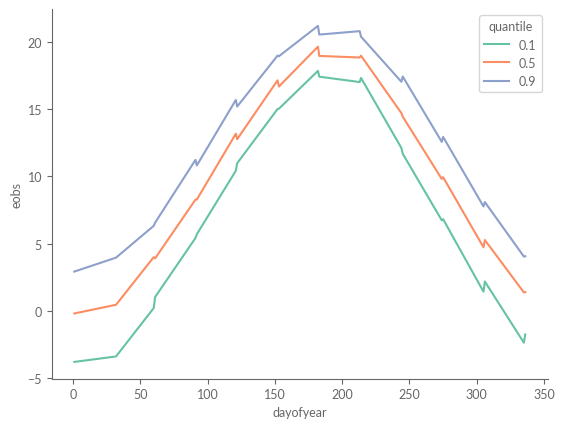

In [65]:
eobs_daily_clim.plot.line(x='dayofyear')

In [68]:
eobs_test = eobs_daily.isel(time=0)
eobs_test = eobs_test.compute()

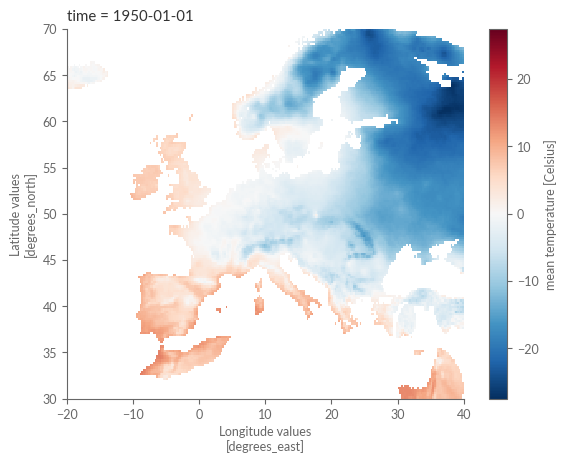

In [69]:
eobs_test.plot()

In [41]:
# land_sea_mask['eobs'] = lsm.mask(eobs_daily).notnull()
# eobs_spatial_mean = weighted_spatial_average(eobs_daily, region_of_interest['Global'], land_only=True)

In [38]:
# eobs_spatial_mean.plot()

In [10]:
eobs_annual = eobs_daily.resample(time='AS').mean()
era5_annual = era5.resample(time='AS').mean()

NameError: name 'era5' is not defined

In [42]:
eobs_annual = weighted_spatial_average(eobs_annual, region_of_interest['Europe'], land_only=True)
era5_annual = weighted_spatial_average(era5_annual, region_of_interest['Europe'], land_only=True)

In [51]:
eobs_annual = eobs_annual - eobs_annual.sel(time=ref_period).mean()
era5_annual = era5_annual - era5_annual.sel(time=ref_period).mean()

Text(0.0, 1.0, 'European annual temperature anomalies (in ºC)')

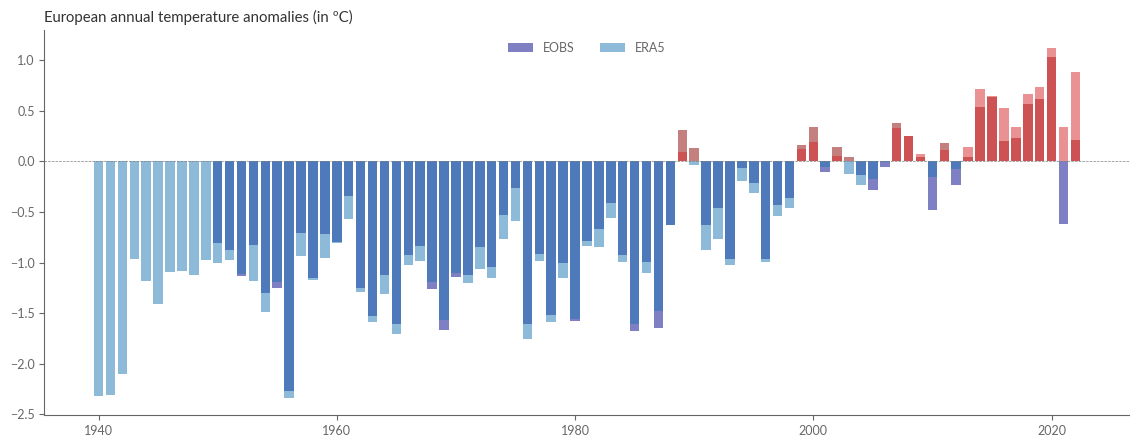

In [61]:
# make red and blue colors for above and below zero
clrs_era5 = np.where(era5_annual > 0, 'tab:red', 'tab:blue')
clrs_eobs = np.where(eobs_annual > 0, 'darkred', 'darkblue')

fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(111)
ax.bar(eobs_annual.time.dt.year, eobs_annual, color=clrs_eobs, label='EOBS', alpha=.5)
ax.bar(era5_annual.time.dt.year, era5_annual, color=clrs_era5, label='ERA5', alpha=.5)
ax.axhline(0, color='.5', lw=.5, ls='--')
ax.legend(ncols=2, frameon=False, loc='upper center')
ax.set_title('European annual temperature anomalies (in ºC)')


In [384]:

eobs = eobs_daily.resample({'time':'MS'}).mean()
eobs

<xarray.DataArray 'eobs' (time: 876, lat: 201, lon: 464)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -40.38 -40.12 -39.88 -39.62 ... 74.88 75.12 75.38
  * lat      (lat) float64 25.38 25.62 25.88 26.12 ... 74.62 74.88 75.12 75.38
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2022-12-01
Attributes:
    standard_name:  air_temperature
    long_name:      mean temperature
    units:          Celsius
    cell_methods:   time: mean

In [62]:
eobs_daily_quantiles = eobs_daily.sel(time=ref_period).groupby('time.dayofyear').quantile([.1, .5, .9], 'time')
eobs_daily_climatology = eobs_daily_quantiles.sel(quantile=.5)
eobs_daily_anom = eobs_daily.groupby('time.dayofyear') - eobs_daily_climatology


/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, ax

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


## Section 3. Visualising recent temperature anomalies

We calculate the climatology, i.e., the mean over a specific period, and anomalies (deviations from this mean). Here we use the time period 1991-2020 as a reference period in accordance with [current standards](https://climate.copernicus.eu/new-decade-brings-reference-period-change-climate-data). However, you may want to use the historical base period of 1961-1990 if you are particular interested in assessing changes due to climate change.

In [ ]:
reference_period = slice('1991', '2020')

In [ ]:
reference_period = slice('1991', '2020')
climatology = t2m.sel(time=reference_period).groupby('time.month').mean()
anomalies = t2m.groupby('time.month') - climatology

Next, we select a month of interest (`moi`) - let's go with March 2022.

In [ ]:
moi = 3  # March (1 = January, 2 = February, etc.)

number2month = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

Plotting our data is a great way to visualize the temperature anomalies. We'll create maps showing the anomalies in three different regions: globally, Europe and the Arctic.

To start, three different types of map projections are specified, each for the corresponding region. The `EqualEarth()` projection is used for the global view, while `NearsidePerspective()` is used for the European and Arctic views. The central longitude and latitude are adjusted according to the region in focus. These projections help in providing an accurate spatial representation of the temperature anomalies.

In [ ]:
SUBTITLES = ['Global', 'Europe', 'Arctic']
proj_maps = [
  ccrs.EqualEarth(),  # Global
  ccrs.NearsidePerspective(central_longitude=10, central_latitude=50),  # Europe
  ccrs.NearsidePerspective(central_longitude=0, central_latitude=90)  # Artic
]
proj_data = ccrs.PlateCarree()  # projection for the data

Next, a color normalization is established with the `Normalize()` function, which sets the range of temperature anomalies from -6 to 6. This ensures a consistent scale for interpreting the temperature anomaly maps across all three regions.

In [ ]:
norm = mcolors.Normalize(vmin=-6, vmax=6)

Finally, we create a figure with three subplots dedicated for the three regions (`axes`), an axis for the colorbar (`cax`) and another for the title/subtitle (`tax`).

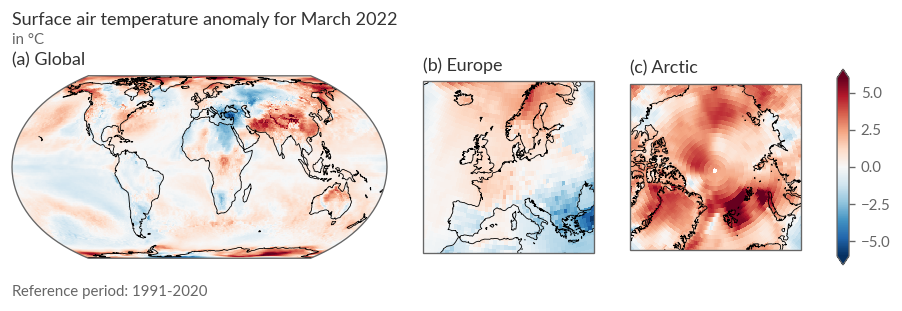

In [ ]:
time = '2022-{0:02d}-01'.format(moi)

# Create the figure
fig = plt.figure(figsize=(9, 2.5), dpi=120)
gs = GridSpec(3, 4, figure=fig, width_ratios=[2.2, 1, 1, 0.07], height_ratios=[.05, 1, .05])

# Add the axes
tax = fig.add_subplot(gs[0, 0])
bax = fig.add_subplot(gs[2, 0])
axes = [fig.add_subplot(gs[1, i], projection=proj_maps[i]) for i in range(3)]
cax = fig.add_subplot(gs[1, 3])

# Set the extent of the maps
axes[1].set_extent([-15, 30, 33, 70], crs=proj_data)
axes[2].set_extent([-180, 180, 70, 90], crs=proj_data)

# Add coastlines and anomlies
for ax in axes:
  ax.coastlines(lw=0.5)
  anomalies.sel(time=time, drop=True).plot(
    ax=ax, transform=proj_data, cbar_ax=cax, norm=norm,
    cbar_kwargs=dict(label='')
  )

# Add titles, labels and text
for i, ax in enumerate(axes):
  ax.set_title(f'({ABC[i]}) {SUBTITLES[i]}')

title = f'Surface air temperature anomaly for {number2month[moi]} 2022'
tax.set_title(title)
tax.text(0, 0, 'in °C', ha='left', va='bottom', transform=tax.transAxes)
tax.axis('off')
bax.axis('off')
ref_start = reference_period.start
ref_end = reference_period.stop
bax.text(0, 0, f'Reference period: {ref_start}-{ref_end}', ha='left', va='bottom', transform=bax.transAxes)
fig.subplots_adjust(bottom=.0, hspace=0.02)
plt.show()

## Temperature anomalies over the last 70 years

To analyze long-term trends, we examine the weighted mean temperature anomalies over the past 70 years globally, in Europe and the Arctic regions.

The first step is to define the subregions we're interested in (Europe and the Arctic)

In [ ]:
regions = {
    'europe': {'longitude': slice(-15, 30), 'latitude': slice(70, 30)},
    'arctic': {'longitude': slice(None, None), 'latitude': slice(None, 70)},
}

The second step is to to compute weights as the cosine of the latitude. These weights account for the spherical geometry of the Earth in our calculations. Since the Earth's surface area is greater at the equator than at the poles, the data points representing temperatures from different latitudes aren't equivalent. Weighting by the cosine of the latitude provides a way to adjust for this effect and treat the data more accurately.

In [ ]:
weights = np.cos(np.deg2rad(t2m.latitude))
weights.name = 'weights'

We calculate the weighted mean temperature anomalies for each of our regions of interest. Each of these series of mean anomalies is smoothed using a rolling mean with a window size of 12 months to remove short-term fluctuations and highlight longer-term trends.

In [ ]:
anom_mean_global = anomalies.weighted(weights).mean(('latitude', 'longitude'))
anom_mean_europe = anomalies.sel(regions['europe']).weighted(weights).mean(('latitude', 'longitude'))
anom_mean_arctic = anomalies.sel(regions['arctic']).weighted(weights).mean(('latitude', 'longitude'))

anom_mean_global = anom_mean_global.rolling(time=12, center=True).mean()
anom_mean_europe = anom_mean_europe.rolling(time=12, center=True).mean()
anom_mean_arctic = anom_mean_arctic.rolling(time=12, center=True).mean()

In addtion, let's have a look at the mean anomalies for a our month of interest (March) across years. Using the `sel` function, we extract data for the specific month from each of the rolling mean anomaly time series.

In [ ]:
is_moi = anom_mean_global.time.dt.month == moi

anom_mean_moi_global = anom_mean_global.sel(time=is_moi)
anom_mean_moi_europe = anom_mean_europe.sel(time=is_moi)
anom_mean_moi_arctic = anom_mean_arctic.sel(time=is_moi)

And finally, let's visualize these long-term trends. We want to produce a bar plot with positive anomalies colored in red and negative anomalies colored in blue.

In [ ]:
clrs_cool_warm = sns.color_palette('RdBu_r', as_cmap=False)
blue, red = clrs_cool_warm[0], clrs_cool_warm[-1]

colors_global = [red if anom >=0 else blue for anom in anom_mean_global]
colors_europe = [red if anom >=0 else blue for anom in anom_mean_europe]
colors_arctic = [red if anom >=0 else blue for anom in anom_mean_arctic]

We must take care of the proper bar width ourselves which depends on the number of days within a given month.

In [ ]:
bar_width = pd.to_datetime(anom_mean_global.time.values).days_in_month
bar_width = [dt.timedelta(days=i) for i in bar_width]
bar_width_moi = dt.timedelta(days=31) 

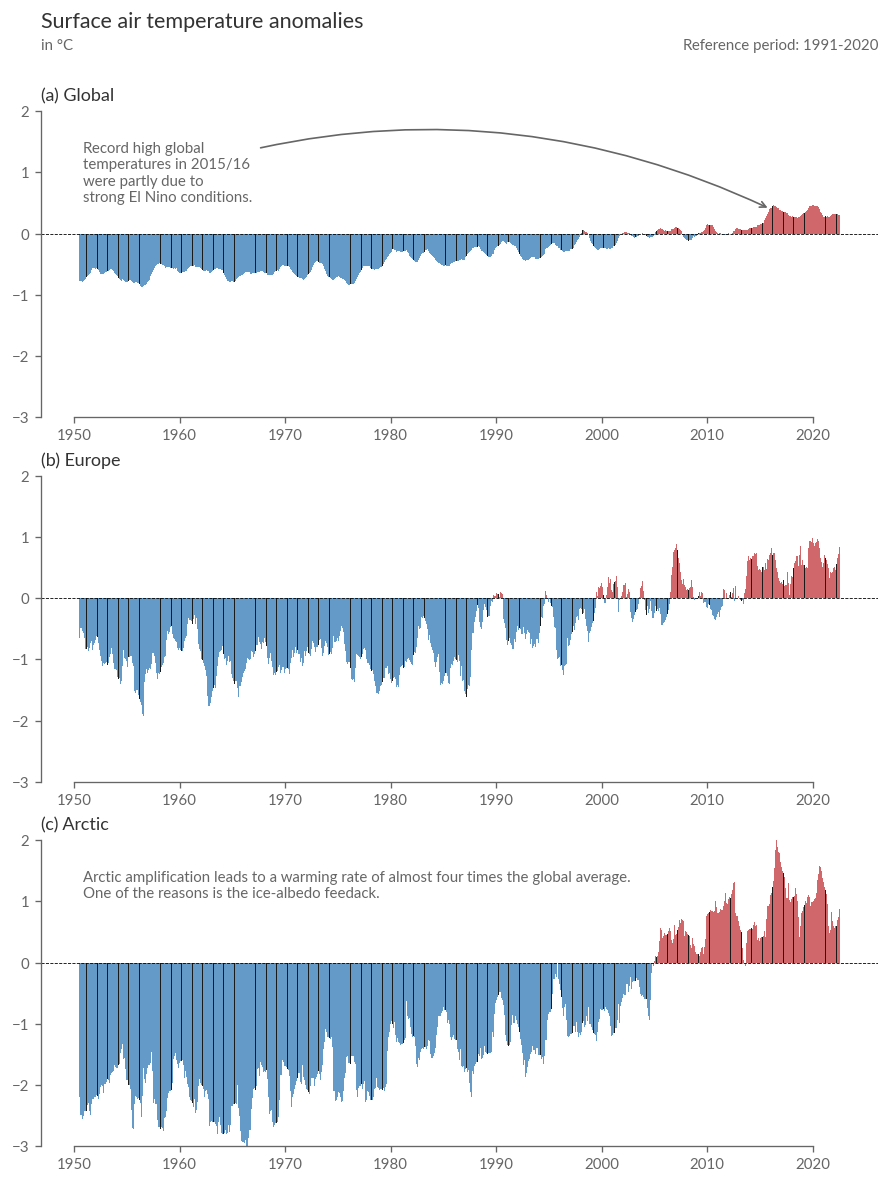

In [ ]:
fig = plt.figure(figsize=(9, 12), dpi=120)
gs = GridSpec(4, 1, figure=fig, height_ratios=[.05, 1, 1, 1], hspace=0.25)

tax = fig.add_subplot(gs[0, 0])
axes = [fig.add_subplot(gs[i, 0]) for i in range(1, 4)]

axes[0].bar(pd.to_datetime(anom_mean_global.time), anom_mean_global.values, width=bar_width, color=colors_global, alpha=.75, align='edge')
axes[1].bar(pd.to_datetime(anom_mean_europe.time), anom_mean_europe.values, width=bar_width, color=colors_europe, alpha=.75, align='edge')
axes[2].bar(pd.to_datetime(anom_mean_arctic.time), anom_mean_arctic.values, width=bar_width, color=colors_arctic, alpha=.75, align='edge')

axes[0].bar(pd.to_datetime(anom_mean_moi_global.time), anom_mean_moi_global.values, width=bar_width_moi, color='.1', align='edge')
axes[1].bar(pd.to_datetime(anom_mean_moi_europe.time), anom_mean_moi_europe.values, width=bar_width_moi, color='.1', align='edge')
axes[2].bar(pd.to_datetime(anom_mean_moi_arctic.time), anom_mean_moi_arctic.values, width=bar_width_moi, color='.1', align='edge')

# Add annotations describing the data
desc_global = 'Record high global \ntemperatures in 2015/16 \nwere partly due to \nstrong El Nino conditions.'
desc_artic = 'Arctic amplification leads to a warming rate of almost four times the global average.\nOne of the reasons is the ice-albedo feedack.'
axes[0].annotate(
  desc_global,
  xy=(dt.datetime(2016, 1, 1), 0.4),
  xytext=(0.05, 0.9),
  textcoords=axes[0].transAxes,
  ha='left', va='top',
  arrowprops=dict(arrowstyle='->', color='.4', connectionstyle='arc3,rad=-0.2')
)
axes[2].text(0.05, 0.9, desc_artic, transform=axes[2].transAxes, ha='left', va='top')


for i, ax in enumerate(axes):
  ax.set_ylim(-3, 2)
  ax.axhline(0, color='k', ls='--', lw=0.5)
  ax.set_title(f'({ABC[i]}) {SUBTITLES[i]}')
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
tax.axis('off')
tax.set_title('Surface air temperature anomalies', fontsize='x-large')
tax.text(0, 0, 'in °C', ha='left', va='bottom', transform=tax.transAxes)
tax.text(1, 0, f'Reference period: {ref_start}-{ref_end}', ha='right', va='bottom', transform=tax.transAxes)

sns.despine(fig, trim=True)

In conclusion, by analyzing and visualizing this temperature data, we can see the stark reality of rising temperatures - an irrefutable indicator of global warming.

### References

[1] Rantanen, M., Karpechko, A.Y., Lipponen, A. et al. The Arctic has warmed nearly four times faster than the globe since 1979. Commun Earth Environ 3, 168 (2022). https://doi.org/10.1038/s43247-022-00498-3